# Test 19

Plain evolution of the GS.

In [1]:
import os
import sys

import numpy as np
import pandas as pd

from tqdm import tqdm
from IPython.display import clear_output

import matplotlib as mpl 
#mpl.use('pgf')
import matplotlib.pyplot as plt

sys.path.insert(0, '../icenumerics/')
import icenumerics as ice

import auxiliary as aux
import montecarlo_tools as mc
import chirality_tools as chir
ureg = ice.ureg

%reload_ext autoreload
%autoreload 2

idx = pd.IndexSlice

/home/leogabac/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [37]:
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

In [26]:
quench_time = 120*ureg.s
rotation_time = 0*ureg.s
total_time = quench_time + rotation_time
data_path = "../data/test19/"
runs = 10

params = {
    "particle_radius":1.4*ureg.um,
    "particle_susceptibility":0.4,
    "particle_diffusion":0.14*ureg.um**2/ureg.s,
    "particle_temperature":300*ureg.K,
    "particle_density":1000*ureg.kg/ureg.m**3,

    "trap_sep":3*ureg.um,
    "trap_height":8*ureg.pN*ureg.nm,
    "trap_stiffness":100e-3*ureg.pN/ureg.nm,
    "height_spread":0,
    "susceptibility_spread":0,
    "isperiodic":True,

    "total_time":total_time,
    "framespersec":20*ureg.Hz,
    "dt":0.1*ureg.ms,
    "max_field":10*ureg.mT,
    "sim_temp":300*ureg.K,
    "sim_dipole_cutoff":40*ureg.um,
}

params["lattice_constant"] = params["trap_sep"]+(2*params["particle_radius"]+1*ureg.um)*np.sqrt(2)
params["size"] = 10

Importing the GS, reconstruct the colloidal ice object from there.

In [14]:
def get_md_colloid(params, ctrj, realization):
    
    N = params['size']
    a = params['lattice_constant']
    
    particle = ice.particle(
        radius = params['particle_radius'],
        susceptibility = params['particle_susceptibility'],
        diffusion = params["particle_diffusion"],
        temperature = params["particle_temperature"],
        density = params["particle_density"]
    )
    
    trap = ice.trap(
       trap_sep = params["trap_sep"], 
       height = params["trap_height"],
       stiffness = params["trap_stiffness"]
    )
    
    params['particle'] = particle
    params['trap'] = trap
    
    col = aux.get_colloids_from_ctrj2(ctrj,params)
    
    world = ice.world(
        field = params["max_field"],
        temperature = params["sim_temp"],
        dipole_cutoff = params["sim_dipole_cutoff"],
        boundaries=['p', 'p', 'p']
    )
    
    col.simulation(world,
        name = f"./lammps_files/test{realization}",
        include_timestamp = False,
        targetdir = r".",
        framerate = params["framespersec"],
        timestep = params["dt"],
        run_time = params["total_time"],
        output = ["x","y","z","mux","muy","muz"],
        processors=1)
    
    col.sim.field.fieldx = "v_Bmag"
    col.sim.field.fieldy = "0"
    col.sim.field.fieldz = "0"   

    col.run_simulation()
    col.load_simulation()

    return col   
    
    

In [28]:
gspath = '../data/test16'
smolaf = pd.read_csv(os.path.join(gspath,'smolaf.csv'),index_col=0)

In [29]:
def jesus_take_the_wheels(params,ctrj,data_path,realization):
    trj_path = os.path.join(data_path,'trj')
    ctrj_path = os.path.join(data_path,'ctrj')

    try:
        os.mkdir(trj_path)
        os.mkdir(ctrj_path)
    except:
        pass
    
    col = get_md_colloid(params,ctrj,realization)

    col.trj.to_csv(os.path.join(trj_path,f"trj{realization}.csv"))

    trj = ice.get_ice_trj(col.trj, bounds = col.bnd)
    trj.to_csv(os.path.join(ctrj_path,f"ctrj{realization}.csv"))
    
    return None

# MD Shenaningans

In [30]:
import concurrent.futures

In [ ]:
runs = 5
realizations = list(range(1,runs+1))
with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
    # map the function to the realizations
    results = list(
        executor.map(
            jesus_take_the_wheels,
            [params] * len(realizations),
            [smolaf] * len(realizations),
            [data_path] * len(realizations),
            realizations,
        )
    )

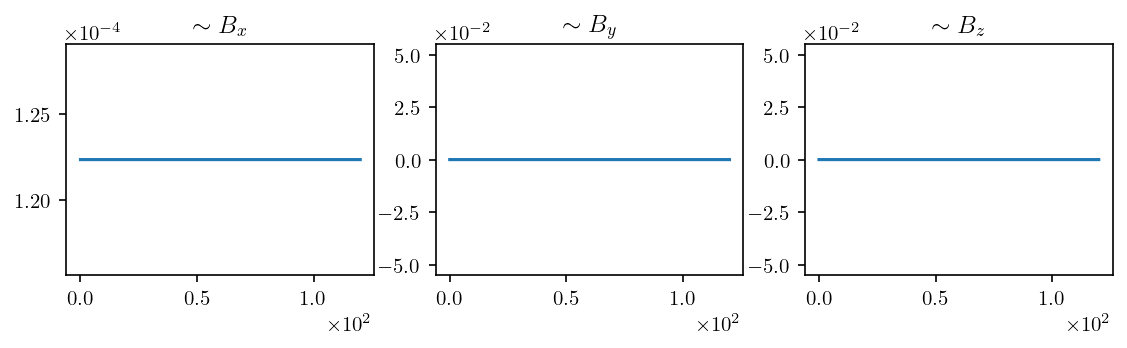

In [38]:
trj_raw = trj = pd.read_csv(os.path.join(data_path,'trj/trj1.csv'), index_col=[0,1])
ctrj_raw = pd.read_csv(os.path.join(data_path,'ctrj/ctrj1.csv'), index_col=[0,1])

fig, axes = plt.subplots(1,3,figsize=(9,2),dpi=150)

ax = axes[0]
ax.plot(np.array(trj_raw.loc[idx[:,1],"t"]),np.array(trj_raw.loc[idx[:,1],"mux"]))
ax.set_title("$\\sim B_x$")
ax.ticklabel_format(style='sci',scilimits=(0,0))

ax = axes[1]
ax.plot(np.array(trj_raw.loc[idx[:,1],"t"]),np.array(trj_raw.loc[idx[:,1],"muy"]))
ax.set_title("$\\sim B_y$")
ax.ticklabel_format(style='sci',scilimits=(0,0))

ax = axes[2]
ax.plot(np.array(trj_raw.loc[idx[:,1],"t"]),np.array(trj_raw.loc[idx[:,1],"muz"]))
ax.set_title("$\\sim B_z$")
ax.ticklabel_format(style='sci',scilimits=(0,0))

plt.show()

# Vertex Counting

In [ ]:
trj_path = os.path.join(data_path,"trj")
ctrj_path = os.path.join(data_path,"ctrj")
vrt_path = os.path.join(data_path,"vertices")

# Get the number of realizations
_, _, files = next(os.walk(trj_path))
realizations = len(files)

for i in range(1,5+1):
    print("========================================")
    print(f"Working on realization {i}")

    # Importing files
    trj_file = os.path.join(trj_path,f"trj{i}.csv")
    print(f"Opening " + trj_file)
    ctrj_file = os.path.join(ctrj_path,f"ctrj{i}.csv")
    print(f"Opening " + ctrj_file)
    trj_raw = trj = pd.read_csv(trj_file, index_col=[0,1])
    ctrj_raw = pd.read_csv(ctrj_file, index_col=[0,1])

    # Doing shit with the vertices
    v = ice.vertices()
    frames = ctrj_raw.index.get_level_values("frame").unique()

    vrt_file = os.path.join(vrt_path,f"vertices{i}.csv")
    v.trj_to_vertices(ctrj_raw.loc[frames[::10]])

    print(f"Saving vertices to " + vrt_file)
    v.vertices.to_csv(vrt_file)
    
    clear_output(wait=True)

In [41]:
vrt_path = os.path.join(data_path,"vertices/")
vertices = aux.getVerticesDict(vrt_path)
counts = aux.getVerticesCount(vertices)
vrt_ts = aux.getVerticesAverage(counts,params["framespersec"])
types = vrt_ts.columns.to_list()[1:]
t = vrt_ts["time"].to_numpy()
vrt_counts = vrt_ts[types].to_numpy()

/home/leogabac/.local/lib/python3.8/site-packages/pandas/core/construction.py:580: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.array(data, copy=copy)


In [42]:
field = t * params["max_field"].magnitude / quench_time.magnitude
params["max_field"]

10 <Unit('millitesla')>

In [1]:
region_limit = np.round( params["lattice_constant"].magnitude * params["size"] )
last_frame = trj_raw.index.get_level_values("frame").unique()[-1]
ctrj_sel = ctrj_raw.loc[last_frame,:]
v = ice.vertices()
v = v.trj_to_vertices(ctrj_sel)

NameError: name 'np' is not defined

In [44]:
def drop_shit(ctrj):
    return ctrj.drop(columns={'type','t'})

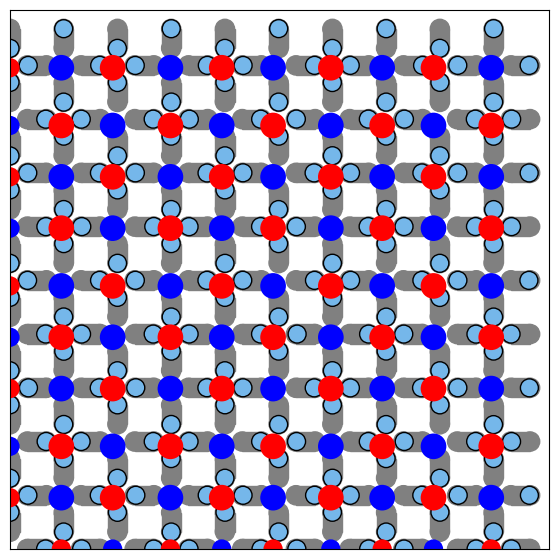

In [49]:
fig, ax = plt.subplots(figsize=(7,7))
ice.draw_frame((ctrj_raw),
               region=[0,region_limit,0,region_limit],
               radius=params["particle_radius"].magnitude,
               cutoff=params["trap_sep"].magnitude/2,
               particle_color='#75b7ea',
               trap_color='gray',
               ax = ax)

v.display(ax,dpl_scale=0.5,dpl_width=2.5,circle_scale=0.5)
plt.show()

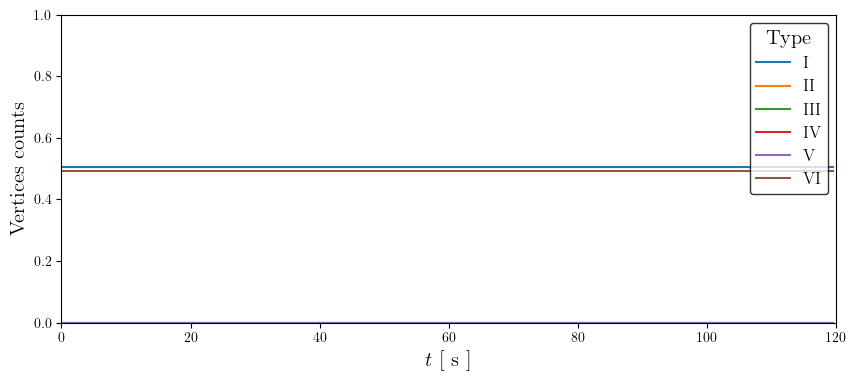

In [47]:
fig, ax = plt.subplots(figsize=(10,4))

ax.plot(t,vrt_counts[:,0])
ax.plot(t,vrt_counts[:,1])
ax.plot(t,vrt_counts[:,2])
ax.plot(t,vrt_counts[:,3])
ax.plot(t,vrt_counts[:,4])
ax.plot(t,vrt_counts[:,5])

ax.legend(types, fontsize=12,title='Type', title_fontsize=15, edgecolor='black')
ax.set_xlabel("$t$  [ s ] ", fontsize=15)
ax.set_ylabel("Vertices counts", fontsize=15)
ax.set_xlim(0,params['total_time'].magnitude)
ax.set_ylim(0,1)
plt.show()

fig.savefig('../data/vertices_full.pdf', bbox_inches='tight')
fig.savefig('../data/vertices_full.jpeg', dpi=300)